<a href="https://colab.research.google.com/github/rahulkhattri0/Fake-news-detection/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# URL to the dataset
dataset_url = "https://www.kaggle.com/c/fake-news/data"

In [ ]:
# Download the dataset manually from Kaggle and save it as "train.csv" in your working directory.
# Load the dataset using pandas
df = pd.read_csv("/content/gdrive/My Drive/fake_news/train.csv")

In [ ]:
# Display the first few rows of the dataset
print(df.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [ ]:
# data preprocessing now
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Define functions for preprocessing
def clean_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters, numbers, and symbols
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    if isinstance(text, str):
        # Tokenization (split text into words)
        words = text.split()
        # Lowercasing
        words = [word.lower() for word in words]
        # Stopword removal
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        # Join the words back into a single string
        return ' '.join(words)
    else:
        return text

In [ ]:
# Download the "stopwords" and "wordnet" dataset
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Apply text cleaning and preprocessing to the 'text' column
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
# Handling missing data (remove rows with missing text)
df.dropna(subset=['text'], inplace=True)

In [ ]:
# Display the preprocessed text
print(df['text'].head())

0    house dem aide didnt even see comeys letter ja...
1    ever get feeling life circle roundabout rather...
2    truth might get fired october 29 2016 tension ...
3    video 15 civilian killed single u airstrike id...
4    print iranian woman sentenced six year prison ...
Name: text, dtype: object


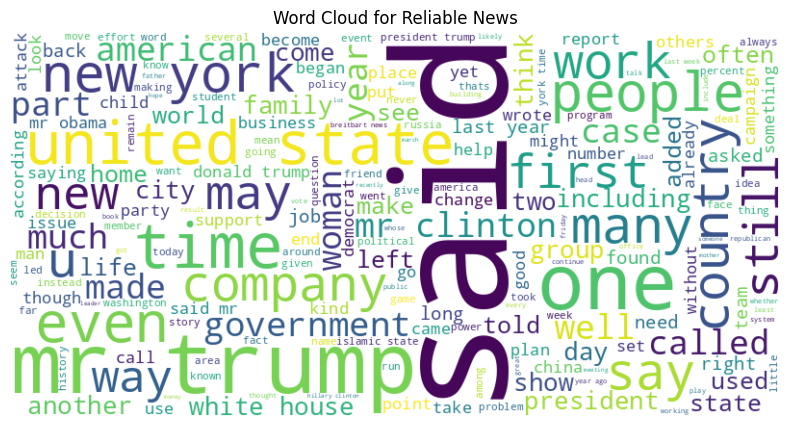

In [ ]:
#Data Visualization
#Word Cloud
'''
A word cloud is a data visualization technique that displays the most frequently occurring words in a piece of text data.
It provides a visual representation of text data where the size of each word is proportional to its frequency in the text.
Common words are typically displayed in a larger and bolder font, making them more prominent in the visualization.
'''
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all the text in your dataset (either reliable or unreliable)
text = ' '.join(df[df['label'] == 0]['text'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Reliable News")
plt.show()

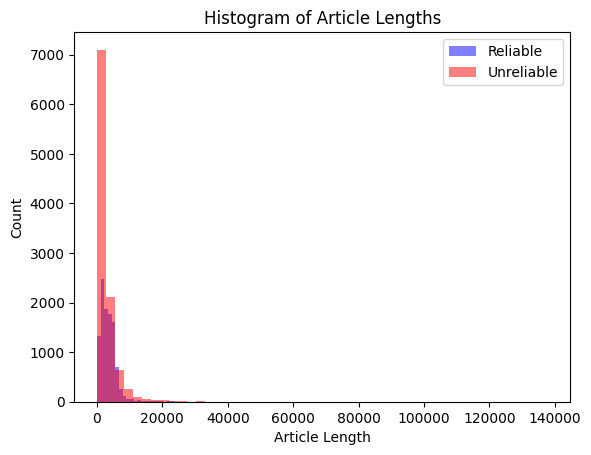

In [ ]:
#Histogram of Article Lengths
'''
A histogram for article length is a data visualization that provides insight into the distribution of article lengths within a dataset.
It shows how many articles fall into different length ranges or bins. Each bar in the histogram represents a range of article lengths,
and the height of the bar indicates the number of articles that have lengths within that range.
'''
import matplotlib.pyplot as plt


reliable_articles = df[df['label'] == 0]
unreliable_articles = df[df['label'] == 1]

plt.hist([len(article) for article in reliable_articles['text']], bins=50, alpha=0.5, label='Reliable', color='blue')
plt.hist([len(article) for article in unreliable_articles['text']], bins=50, alpha=0.5, label='Unreliable', color='red')
plt.xlabel('Article Length')
plt.ylabel('Count')
plt.title('Histogram of Article Lengths')
plt.legend(loc='upper right')
plt.show()

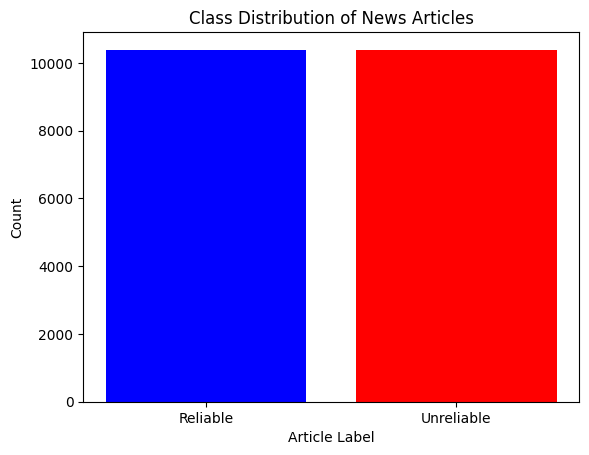

In [ ]:
#bar chart
'''
A Bar Chart for Class Distribution is a data visualization that displays the distribution of classes or categories in a dataset.
'''
import matplotlib.pyplot as plt

# Assuming you have a DataFrame with a 'label' column
# df is your processed dataset
reliable_count = df[df['label'] == 0]['label'].count()
unreliable_count = df[df['label'] == 1]['label'].count()

# Create a bar chart
labels = ['Reliable', 'Unreliable']
counts = [reliable_count, unreliable_count]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Article Label')
plt.ylabel('Count')
plt.title('Class Distribution of News Articles')
plt.show()

In [ ]:
!pip install transformers

In [ ]:
# Model training using BERT
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and prepare data for BERT
X_train_encoded = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test_encoded = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=128)
y_train_tensor = torch.tensor(list(y_train))
y_test_tensor = torch.tensor(list(y_test))

# Create DataLoader
train_dataset = TensorDataset(X_train_encoded.input_ids, X_train_encoded.attention_mask, y_train_tensor)
test_dataset = TensorDataset(X_test_encoded.input_ids, X_test_encoded.attention_mask, y_test_tensor)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model and datasets to the GPU
model.to(device)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)


# Define the BERT fine-tuning parameters
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device)
        )
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = np.argmax(logits.to("cpu").numpy(), axis=1)
        all_preds.extend(preds)

# Calculate accuracy and generate classification report
accuracy = accuracy_score(list(y_test), all_preds)
print(f"Accuracy: {accuracy:.2f}")

classification_rep = classification_report(list(y_test), all_preds)
print(classification_rep)

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2079
           1       0.99      0.97      0.98      2074

    accuracy                           0.98      4153
   macro avg       0.98      0.98      0.98      4153
weighted avg       0.98      0.98      0.98      4153



In [ ]:
output_dir = "/content/gdrive/My Drive/fake_news"

# Save the model to the specified directory in Google Drive
model.save_pretrained(output_dir)

# Save the tokenizer as well
tokenizer.save_pretrained(output_dir)

('/content/gdrive/My Drive/fake_news/tokenizer_config.json',
 '/content/gdrive/My Drive/fake_news/special_tokens_map.json',
 '/content/gdrive/My Drive/fake_news/vocab.txt',
 '/content/gdrive/My Drive/fake_news/added_tokens.json')

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token("2X3vT2UyrHJStb1ZjD3PB8baFC2_2YMSPBuvDzhWB1UpLkXXw")

In [ ]:
!pip install googletrans==4.0.0-rc1
!pip install bert-extractive-summarizer
!pip install deep-translator

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
from summarizer import Summarizer,TransformerSummarizer
from googletrans import Translator


# Load the trained models and tokenizers
fake_news_model_output_dir = "/content/gdrive/My Drive/fake_news"
sentiment_model_output_dir = "nlptown/bert-base-multilingual-uncased-sentiment"

fake_news_model = BertForSequenceClassification.from_pretrained(fake_news_model_output_dir)
fake_news_tokenizer = BertTokenizer.from_pretrained(fake_news_model_output_dir)

sentiment_model = BertForSequenceClassification.from_pretrained(sentiment_model_output_dir)
sentiment_tokenizer = BertTokenizer.from_pretrained(sentiment_model_output_dir)

# Title and description
st.title("News Article Classification and Sentiment Analysis 📰")
st.write("This app classifies news articles as reliable or unreliable and performs sentiment analysis.")

# Text input box
user_input = st.text_area("Enter a news article:")


if st.button("Analyze"):

    # Translate user input to English using Googletrans
    translator = Translator()
    user_input_english = translator.translate(user_input, dest='en').text

    # Tokenize the user input for fake news classification
    fake_news_inputs = fake_news_tokenizer(user_input_english, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Perform fake news classification inference
    with torch.no_grad():
        fake_news_logits = fake_news_model(**fake_news_inputs).logits

    # Determine the predicted class for fake news
    fake_news_predicted_class = "Unreliable" if fake_news_logits[0][1] > 0.5 else "Reliable"

    # Tokenize the user input for sentiment analysis
    sentiment_inputs = sentiment_tokenizer(user_input_english, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Perform sentiment analysis inference
    with torch.no_grad():
        sentiment_logits = sentiment_model(**sentiment_inputs).logits

    # Determine the predicted sentiment class
    sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
    sentiment_predicted_class = sentiment_labels[torch.argmax(sentiment_logits, dim=1).item()]

    # Display the translated and summarized input to the user
    bert_model = Summarizer()
    bert_summary = ''.join(bert_model(user_input_english, min_length=60))
    st.write(f"Translated and summarized Input (English): {bert_summary}")

    # Display the results
    st.write(f"Fake News Classification: {fake_news_predicted_class}")
    st.write(f"Sentiment Analysis: {sentiment_predicted_class}")

    # Fake News confidence scores
    fake_news_probabilities = torch.softmax(fake_news_logits, dim=1)[0].tolist()
    reliable_confidence = fake_news_probabilities[0]
    unreliable_confidence = fake_news_probabilities[1]

    # Visualize fake news confidence with a bar chart
    fake_news_confidence_labels = ["Reliable", "Unreliable"]
    fake_news_confidence_values = [reliable_confidence, unreliable_confidence]
    fig_fake_news, ax_fake_news = plt.subplots(figsize=(5, 3))
    ax_fake_news.bar(fake_news_confidence_labels, fake_news_confidence_values, color=['blue', 'red'])
    ax_fake_news.set_ylabel("Confidence")
    ax_fake_news.set_title("Fake News Classification Confidence")
    st.pyplot(fig_fake_news)


Overwriting app.py


In [ ]:
!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect()
print(url)

nohup: appending output to 'nohup.out'
NgrokTunnel: "https://5b8f-35-222-229-194.ngrok-free.app" -> "http://localhost:80"


In [ ]:
testing = pd.read_csv("/content/gdrive/My Drive/fake_news/test.csv")

In [ ]:
testing['text'][59] #Reliable

'KABUL, Afghanistan  —   A United States military investigation into claims of civilian casualties during a joint operation by Afghan and American forces found that 33 civilians were killed and 27 others were wounded during a firefight and airstrikes in Kunduz Province last year, American military officials said on Thursday. In early November, Afghan Special Forces, accompanied by American military advisers, came under intense fire during an operation to arrest Taliban commanders in Boz Qandahari, a village in Kunduz, the United States military command in Afghanistan said in a statement. They called in American airstrikes, which resulted in some of the civilian casualties. Two American soldiers and three Afghan commandos were killed, and four American soldiers and 11 commandos were wounded, the statement said. “Regardless of the circumstances, I deeply regret the loss of innocent lives,” said Gen. John W. Nicholson Jr. the commander of United States forces in Afghanistan. “On this occa

In [ ]:
testing['text'][1128] #Unreliable

'Archives Michael’s Latest Video Trump And Clinton Have Both Assembled An Army Of Lawyers To File Lawsuits And Contest The Election Results By Michael Snyder, on November 1st, 2016 \nWhat happens when you get thousands of lawyers involved in the craziest election in modern American history? Unfortunately, we may be about to find out. We all remember the legal tug of war between Al Gore and George W. Bush in 2000, and with each passing day it is becoming more likely that we could see something similar (or even worse) in 2016. In a brand new article entitled “ Clinton, Trump Prepare for Possibility of Election Overtime “, Bloomberg discusses the armies of lawyers that Clinton and Trump are both assembling for this election. It would be nice if it was the American people that actually decided the outcome of this election, but if things are very close on November 8th it may come down to what the courts decide. \nTraditionally, there has been a lot of pressure on the losing candidate to con

In [ ]:
testing['text'][2] #Unreliable

'Videos #NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police Amnesty International are sending a delegation of human rights observers to monitor the response of law enforcement to the protests. Be Sociable, Share! (Rob Wilson photo) \nNative American leaders vowed on Saturday to protest through the winter against a North Dakota oil pipeline they say threatens water resources and sacred lands and are planning lawsuits over police treatment of arrested protesters. \nStanding Rock Sioux Chairman Dave Archambault II said he and other tribal leaders were working on providing food, heat and shelter for protesters opposed to the $3.8 billion Dakota Access Pipeline. \n“We’re just working through some technical details as far as where the land is, and the type of land that can be used for some permanent structures,” Archambault told reporters in Mandan, North Dakota on Saturday morning. \nAt least 10 shelters were being readied on tribal land against temperatures